In [45]:
import numpy as np
import cv2
from PIL import ImageEnhance
import copy
import matplotlib.pyplot as plt
from skimage import color
import random

In [46]:
# Helper functions
# definition to readfile
def readfile(path):
    file = open(path, 'r')
    return file

# defintion to fetch bounding boxes
def fetch_bboxes(path):
    file = readfile(path)
    lines = file.readlines()
    # print(lines)
    bboxes = np.empty([len(lines),5], dtype=float)
    
    for i,line in enumerate(lines):
        # print(line)
        line = line.split()[0] + ' ' + ' '.join(line.split()[4:8])
        line = line.split()
        bboxes[i,:4] = line[1:]
    return bboxes

# defintion to fetch a random number
def gen_rand_num(begin,end):
    num = random.uniform(begin,end)
    return num

# definition to write augmented values to label file
def save_augbbox(aug_path,label_path,bboxes):
    file_r = readfile(label_path)
    lines = file_r.readlines()
    labels = []
    
    for i,line in enumerate(lines):
        #line[4:8] = '200 300 400 500'
        line = line.split()
        line[4:8] = [str(bbox) for bbox in bboxes[i,:4]]
        line = ' '.join(line)
        line = line + '\n'
        labels.append(line)
    file_w = open(aug_path + '.txt', 'w')
    file_w.writelines(labels)
    
# defintion to save augmented image    
def save_augimg(path, img_arr):    
    image = Image.fromarray(conv2uint8(img_arr))
    image.save(path + '.jpeg')
    
# method to call save_augbbox and save_augimg
def save_augdata(aug_path,label_path,bboxes,img_arr):
    save_augimg(aug_path,img_arr)
    save_augbbox(aug_path,label_path,bboxes)
    
def conv2uint8(image_arr):
    return (image_arr * 255).astype(np.uint8)

In [47]:
# For Spatial Augmentation
class Spatial_Aug:
    def __init__(self, image, label_path):
        self.image = image
        self.image_arr = np.array(image)/255
        self.bboxes = fetch_bboxes(label_path)
        
    def hflip (self):
        # Fetching image width
        image_width = np.array(self.image_arr.shape[:2])[::-1][0]
        # Horizontally stacking image width for further perusal
        image_width = np.hstack((image_width, image_width))
        # Reversing the image co-ordinates in the 1st dimension
        # i.e Hz_flipping the image
        self.image_arr = self.image_arr[:,::-1,:]
        # Calculating the new distance from origin
        self.bboxes[:,[0,2]] = image_width - self.bboxes[:,[0,2]]
        # Interchanging  x1,x2 co-ordinates
        # Method 1: Calculating the bbox width
        box_width = abs(bboxes[:,0] - bboxes[:,2])
        self.bboxes[:,0] -= box_width
        self.bboxes[:,2] += box_width
        # Method 2: Swap co-ordinates
        #bbox_x1 = bboxes[:,0]
        #bboxes[:,0] = bboxes[:,2]
        #bboxes[:,1] = bbox_x1
        
        return self.image_arr,self.bboxes
    
    def translate (self, TxTy):
        rows,cols = self.image_arr.shape[:2]
        # Making a transition matrix
        # Here the shift is Tx=Ty=8
        Tx,Ty = TxTy
        rand_x = gen_rand_num(0,Tx)
        rand_y = gen_rand_num(0,Ty)
        M = np.float32([[1,0,rand_x],[0,1,rand_y]])
        shift_img = cv2.warpAffine(self.image_arr,M,(cols,rows))
        self.bboxes[:,[0,2]] += rand_x
        self.bboxes[:,[1,3]] += rand_y
        return shift_img, self.bboxes

In [109]:
# For Color Augmentation
class Color_Aug:
    def __init__(self, image, label_path):
        self.image = image
        self.image_arr = np.array(image)/255
        self.bboxes = fetch_bboxes(label_path)
    
    # definition to rotate hue of image
    def hue_rotate(self, hue_rot_max):    
        hsv = color.rgb2hsv(color.gray2rgb(self.image_arr))
        rand_hue_rot = gen_rand_num(0,hue_rot_max)
        print("rand_hue_rot = ",rand_hue_rot)
        # Dividing by 180 for normalization
        # and better hue adjustment
        hsv[:, :, 0] = rand_hue_rot/180
        hsv[:, :, 1] = 1  # Turn up the saturation
        return color.hsv2rgb(hsv)
    
    """# defintion to adjust saturation
    def saturation(self, factor):
        rand_fact = gen_rand_num(0,factor)
        converter = ImageEnhance.Color(self.image)
        return converter.enhance(rand_fact)"""
    
    def saturation (self, factor):
        imghsv = color.rgb2hsv(color.gray2rgb(self.image_arr))
        (h, s, v) = cv2.split(imghsv)
        rand_fact = gen_rand_num(0.01,factor)
        s = s*factor
        s = np.clip(s,0,1)
        imghsv = cv2.merge([h,s,v])
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        return imgrgb
    
    def contrast_scale(self, factor):
        factor = gen_rand_num(0.1,factor)
        return cv2.convertScaleAbs(self.image_arr, alpha=factor)

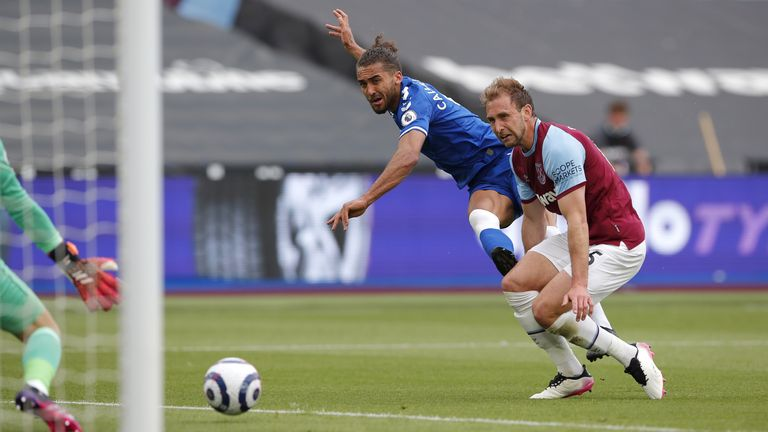

In [49]:
# Test code to fetch bounding boxes and image
from PIL import Image
image = Image.open('sports.jpg')
image

In [50]:
# Class mapping dictionary
test_class = {
    "Player" : 1.0,
    "Ball": 2.0
}

# Augmentation mapping
aug_dict = {
    "hflip":
    ""
}

In [51]:
# Draw bbox on image
# Ref from Paperspace blog
def draw_bbox(img, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    img : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """    
    img = img.copy()
    
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2])/200))
    return img

In [52]:
bboxes = fetch_bboxes('/workspace/experiment/' + 'sports.txt')
bboxes

array([[315.,   6., 514., 403.,   0.],
       [479.,  76., 667., 412.,   0.],
       [196., 348., 269., 423.,   0.]])

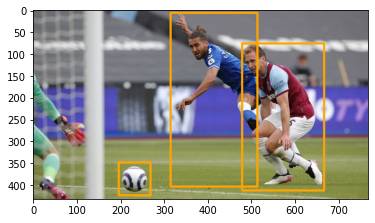

In [53]:
bbox_img = Image.fromarray(draw_bbox(np.asarray(image),
                                     bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_img)

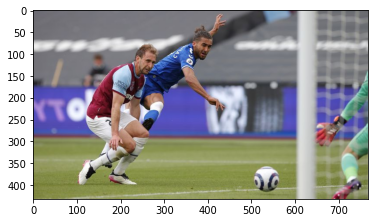

In [54]:
plt.imshow(Image.fromarray(np.asarray(image)[:,::-1,:]))

In [55]:
spat_aug = Spatial_Aug(image, label_path='/workspace/experiment/' + 'sports.txt')

In [56]:
spat_aug.image_arr.shape

(432, 768, 3)

In [57]:
spat_aug.bboxes

array([[315.,   6., 514., 403.,   0.],
       [479.,  76., 667., 412.,   0.],
       [196., 348., 269., 423.,   0.]])

In [58]:
aug_image_arr, aug_bboxes = spat_aug.hflip()

In [59]:
aug_image_arr.shape

(432, 768, 3)

In [60]:
aug_bboxes

array([[254.,   6., 453., 403.,   0.],
       [101.,  76., 289., 412.,   0.],
       [499., 348., 572., 423.,   0.]])

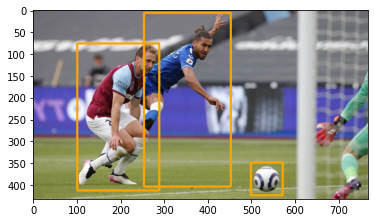

In [61]:
bbox_flipim = Image.fromarray(draw_bbox(conv2uint8(aug_image_arr),
                                     aug_bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_flipim)

In [62]:
save_augdata('sports_hflip','sports.txt',aug_bboxes,aug_image_arr)

In [63]:
shift_img, shift_bboxes = spat_aug.translate((8,8))

In [75]:
shift_img[10]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.42034314, 0.42426471, 0.44387255],
       [0.4192402 , 0.42316176, 0.44276961],
       [0.41668581, 0.42060738, 0.44021523]])

In [64]:
shift_bboxes

array([[259.2785182 ,  10.10534768, 458.2785182 , 407.10534768,
          0.        ],
       [106.2785182 ,  80.10534768, 294.2785182 , 416.10534768,
          0.        ],
       [504.2785182 , 352.10534768, 577.2785182 , 427.10534768,
          0.        ]])

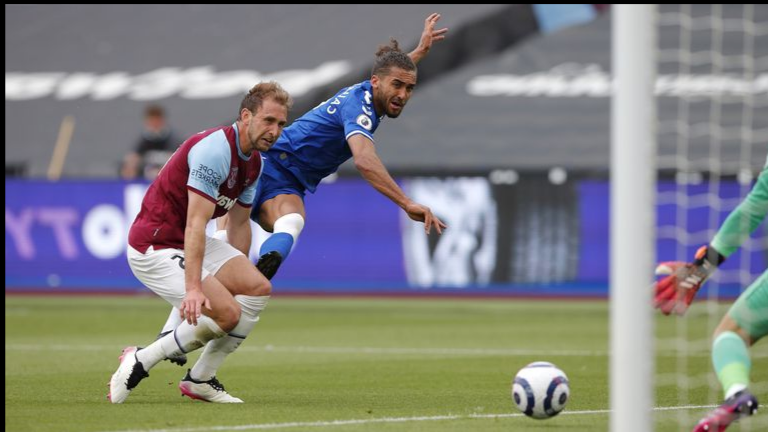

In [66]:
shift_img_view = Image.fromarray(conv2uint8(shift_img))
shift_img_view

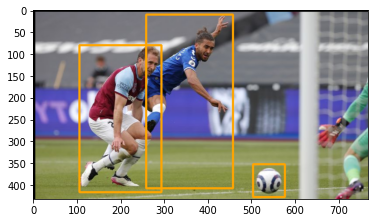

In [110]:
shfbbox_img = Image.fromarray(draw_bbox(conv2uint8(shift_img),
                                     shift_bboxes[:,:4], color=[255,165,0]))
plt.imshow(shfbbox_img)

In [111]:
col_aug = Color_Aug(image, label_path='/workspace/experiment/' + 'sports.txt')

In [112]:
col_aug.image_arr[0]

array([[0.39215686, 0.39607843, 0.41568627],
       [0.39607843, 0.4       , 0.41960784],
       [0.39607843, 0.4       , 0.41960784],
       ...,
       [0.45490196, 0.45098039, 0.48235294],
       [0.45490196, 0.45098039, 0.48235294],
       [0.45490196, 0.45098039, 0.48235294]])

rand_hue_rot =  23.5117328005229


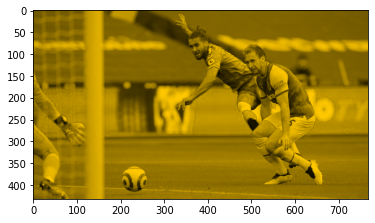

In [113]:
hue_img = col_aug.hue_rotate(25)
plt.imshow(hue_img)

In [114]:
np.array(hue_img)[0]

array([[0.41568627, 0.32578349, 0.        ],
       [0.41960784, 0.32885692, 0.        ],
       [0.41960784, 0.32885692, 0.        ],
       ...,
       [0.48235294, 0.37803178, 0.        ],
       [0.48235294, 0.37803178, 0.        ],
       [0.48235294, 0.37803178, 0.        ]])

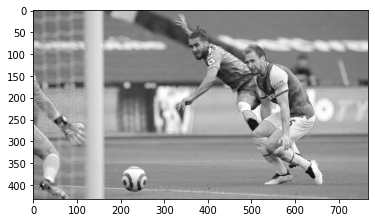

In [115]:
sat_img = col_aug.saturation(0.01)
plt.imshow(sat_img)

In [116]:
np.array(sat_img)[0]

array([[0.41545096, 0.4154535 , 0.41568628],
       [0.41937256, 0.41937506, 0.41960785],
       [0.41937256, 0.41937506, 0.41960785],
       ...,
       [0.4820392 , 0.48204282, 0.48235294],
       [0.4820392 , 0.48204282, 0.48235294],
       [0.4820392 , 0.48204282, 0.48235294]], dtype=float32)

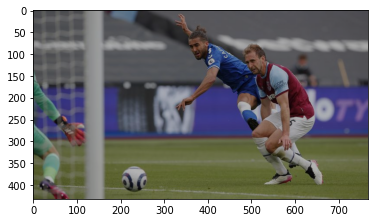

In [121]:
con_scale_img = col_aug.contrast_scale(5)
plt.imshow(con_scale_img)

In [122]:
np.array(con_scale_img[0])

array([[70, 71, 74],
       [71, 72, 75],
       [71, 72, 75],
       ...,
       [81, 81, 86],
       [81, 81, 86],
       [81, 81, 86]], dtype=uint8)